1 imagenet256のラベル付けを変更する 

2 imagenet_class_index_lower.jsonにimagenet-256のデータセットのラベルと会うように文字列を修正（手動＋コード）

3 事前学習済みのresnet50を用いてimagenet-256のデータセットの画像分類

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import json


In [2]:
# 1. 前処理
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. データセット
data_dir = "./imagenet-256"
val_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# 3. モデル
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model = model.to(device)
model.eval()

print("ok")

/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ok


In [3]:
# 4. ImageNet クラスインデックスを読み込み
with open("imagenet_class_index_lower.json", "r") as f:
    class_idx = json.load(f)

# name → index の辞書を作成（空白はアンダースコアに変換）
name_to_idx = {}
for k, v in class_idx.items():
    idx = int(k)
    synset, name = v
    # "afghan hound" → "afghan_hound"
    norm_name = name.replace(" ", "_")
    name_to_idx[norm_name] = idx

# abc順 (val_dataset.classes) → ImageNetインデックス
abc2idx = {}
missing = []
for cls_name in val_dataset.classes:
    if cls_name in name_to_idx:
        abc2idx[cls_name] = name_to_idx[cls_name]
    else:
        missing.append(cls_name)

print(f"[INFO] マッチできたクラス数: {len(abc2idx)}/{len(val_dataset.classes)}")
if missing:
    print(f"[WARN] マッチできなかったクラス例: {missing[:10]} ...")


[INFO] マッチできたクラス数: 999/1000
[WARN] マッチできなかったクラス例: ['tank_suit'] ...


In [4]:
# 5. 精度計算
correct1, correct5, total = 0, 0, 0

# ...existing code...

correct_top1_paths = []
correct_top5_paths = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc="Evaluating", unit="batch")):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        valid_indices = []
        valid_labels_idx = []
        valid_paths = []
        for i, l in enumerate(labels.cpu()):
            cls_name = val_dataset.classes[l]
            if cls_name in abc2idx:
                valid_indices.append(i)
                valid_labels_idx.append(abc2idx[cls_name])
                img_idx = batch_idx * val_loader.batch_size + i
                img_path, _ = val_dataset.samples[img_idx]
                valid_paths.append(img_path)

        if not valid_indices:
            continue

        valid_images = images[valid_indices]
        valid_labels_idx = torch.tensor(valid_labels_idx).to(device)
        valid_outputs = outputs[valid_indices]

        # top-1
        _, pred1 = valid_outputs.max(1)
        correct_mask1 = pred1.eq(valid_labels_idx)
        for idx, is_correct in enumerate(correct_mask1.cpu()):
            if is_correct:
                correct_top1_paths.append(valid_paths[idx])

        # top-5
        _, pred5 = valid_outputs.topk(5, 1, True, True)
        correct_mask5 = pred5.eq(valid_labels_idx.view(-1,1)).any(dim=1)
        for idx, is_correct in enumerate(correct_mask5.cpu()):
            if is_correct:
                correct_top5_paths.append(valid_paths[idx])

        correct1 += correct_mask1.sum().item()
        correct5 += correct_mask5.sum().item()
        total += len(valid_indices)

print(f"Top-1 Accuracy: {100 * correct1 / total:.2f}%")
print(f"Top-5 Accuracy: {100 * correct5 / total:.2f}%")

# 正解画像パスをファイルに保存
with open("correct_top1_images.txt", "w") as f:
    for path in correct_top1_paths:
        f.write(path + "\n")

with open("correct_top5_images.txt", "w") as f:
    for path in correct_top5_paths:
        f.write(path + "\n")

print(f"Top-1で正解した画像数: {len(correct_top1_paths)}")
print(f"Top-5で正解した画像数: {len(correct_top5_paths)}")
# ...existing code...


Evaluating:   1%|▏         | 61/4218 [00:11<12:55,  5.36batch/s] 


KeyboardInterrupt: 

In [5]:
import torch
from PIL import Image
from tqdm import tqdm

batch_size = 32  # メモリに合わせて調整
epsilon = 0.03

# 正解画像パスの読み込み
with open("correct_top1_images.txt") as f:
    correct_paths = [line.strip() for line in f]

adv_correct1, adv_correct5, adv_total = 0, 0, 0

model.eval()
for i in tqdm(range(0, len(correct_paths), batch_size), desc="FGSM Attack (batch)"):
    batch_paths = correct_paths[i:i+batch_size]
    images = []
    labels = []
    for path in batch_paths:
        img = Image.open(path).convert("RGB")
        input_tensor = transform(img)
        images.append(input_tensor)
        cls_name = path.split("/")[-2]
        if cls_name in abc2idx:
            labels.append(abc2idx[cls_name])
        else:
            labels.append(-1)  # 無効値

    # 無効なラベルを除外
    valid_indices = [j for j, l in enumerate(labels) if l >= 0]
    if not valid_indices:
        continue
    images = torch.stack([images[j] for j in valid_indices]).to(device)
    labels = torch.tensor([labels[j] for j in valid_indices]).to(device)
    images.requires_grad = True

    # FGSM
    output = model(images)
    loss = torch.nn.functional.cross_entropy(output, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    perturbed = images + epsilon * data_grad.sign()
    perturbed = torch.clamp(perturbed, 0, 1)

    # 再分類
    output_adv = model(perturbed)
    _, pred1 = output_adv.max(1)
    _, pred5 = output_adv.topk(5, 1, True, True)

    adv_total += len(labels)
    adv_correct1 += pred1.eq(labels).sum().item()
    adv_correct5 += sum([labels[j].item() in pred5[j].cpu().numpy() for j in range(len(labels))])

print(f"[FGSM] Top-1 Accuracy: {100 * adv_correct1 / adv_total:.2f}%")
print(f"[FGSM] Top-5 Accuracy: {100 * adv_correct5 / adv_total:.2f}%")

FGSM Attack (batch):   0%|          | 0/14412 [00:00<?, ?it/s]

FGSM Attack (batch):   1%|          | 157/14412 [00:31<48:21,  4.91it/s]


KeyboardInterrupt: 

数枚だけ敵対的画像を出力

In [1]:
import torch
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F

batch_size = 32
epsilon = 0.03

# 正解画像パス（先頭100枚のみ）
with open("correct_top1_images.txt") as f:
    correct_paths = [line.strip() for line in f][:100]

# 精度カウント用
clean_correct1, clean_correct5 = 0, 0
adv_correct1, adv_correct5 = 0, 0
total = 0

model.eval()
for i in tqdm(range(0, len(correct_paths), batch_size), desc="FGSM Attack (100 samples)"):
    batch_paths = correct_paths[i:i+batch_size]
    images, labels = [], []
    for path in batch_paths:
        img = Image.open(path).convert("RGB")
        input_tensor = transform(img)
        images.append(input_tensor)
        cls_name = path.split("/")[-2]
        labels.append(abc2idx.get(cls_name, -1))

    # 無効ラベルを除外
    valid_indices = [j for j, l in enumerate(labels) if l >= 0]
    if not valid_indices:
        continue
    images = torch.stack([images[j] for j in valid_indices]).to(device)
    labels = torch.tensor([labels[j] for j in valid_indices]).to(device)
    images.requires_grad = True

    # ====== クリーン画像で推論 ======
    output_clean = model(images)
    _, pred1_clean = output_clean.max(1)
    _, pred5_clean = output_clean.topk(5, 1, True, True)

    clean_correct1 += pred1_clean.eq(labels).sum().item()
    clean_correct5 += sum([labels[j].item() in pred5_clean[j].cpu().numpy()
                           for j in range(len(labels))])

    # ====== FGSM 攻撃 ======
    loss = F.cross_entropy(output_clean, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    perturbed = torch.clamp(images + epsilon * data_grad.sign(), 0, 1)

    # 再分類（敵対的画像）
    output_adv = model(perturbed)
    _, pred1_adv = output_adv.max(1)
    _, pred5_adv = output_adv.topk(5, 1, True, True)

    adv_correct1 += pred1_adv.eq(labels).sum().item()
    adv_correct5 += sum([labels[j].item() in pred5_adv[j].cpu().numpy()
                         for j in range(len(labels))])

    total += len(labels)

# ====== 結果表示 ======
print(f"[CLEAN] Total: {total}")
print(f"[CLEAN] Top-1: {clean_correct1}/{total} ({100 * clean_correct1 / total:.2f}%)")
print(f"[CLEAN] Top-5: {clean_correct5}/{total} ({100 * clean_correct5 / total:.2f}%)")

print(f"[FGSM] Total: {total}")
print(f"[FGSM] Top-1: {adv_correct1}/{total} ({100 * adv_correct1 / total:.2f}%)")
print(f"[FGSM] Top-5: {adv_correct5}/{total} ({100 * adv_correct5 / total:.2f}%)")


NameError: name 'model' is not defined

拡散モデルを用いて防御Guided Diffusion


In [2]:
# fgsm_plus_diffusion_eval.py
import os
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets, models
import torch.nn as nn
import torchvision
import math
import sys
sys.path.append("/mnt/data1/gotou/projects/guided-diffusion")  # クローンした場所に置き換え

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import create_model_and_diffusion


# --- guided-diffusion imports (make sure repo is available in PYTHONPATH) ---
from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import create_model_and_diffusion

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion
)

In [3]:
# ---------------- user settings ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8 # VRAM に合わせて調整。256x256 diffusion は重いので小さめ推奨
epsilon = 0.03
num_samples = 100 # correct_top1_images.txt の先頭何枚を使うか

# Diffusion settings
use_ddim = True
ddim_steps = 100     # 速くしたければ 25~50。品質を優先するなら 100+
real_step = 10     # reverse の深さ（実験して調整）
model_path = "/mnt/data1/gotou/projects/guided-diffusion/models/256x256_diffusion_uncond.pt"  # 事前チェックポイント


# ---------------- transforms (あなたの分類用) ----------------
# 既存の分類 transform と同じものを使う想定
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# ImageNet 正規化パラ
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3,1,1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(3,1,1)

In [4]:
# ---------------- load classifier ----------------
clf = models.resnet50(pretrained=True).to(device)
clf.eval()

# ---------------- load paths ----------------
with open("correct_top1_images.txt") as f:
    all_paths = [p.strip() for p in f]
paths = all_paths[:num_samples]

# ---------------- guided-diffusion model load ----------------
defaults = model_and_diffusion_defaults()
defaults.update({
    "image_size": 256,
    "num_channels": 256,
    "num_res_blocks": 2,
    "num_heads": 4,
    "num_head_channels": -1,
    "learn_sigma": True,
    "class_cond": False,
    "use_fp16": False,
    "use_scale_shift_norm": True,
    "resblock_updown": True,
    "attention_resolutions": "32,16,8",
    "diffusion_steps": 1000,
    "timestep_respacing": f"ddim{ddim_steps}" if use_ddim else "1000",  # ★追加
})

print("Creating guided-diffusion model...")
diff_model, diffusion = create_model_and_diffusion(**defaults)

print("Loading checkpoint:", model_path)
ckpt = torch.load(model_path, map_location="cpu")
diff_model.load_state_dict(ckpt)

diff_model.to(device)
diff_model.eval()
print("✅ Model loaded successfully!")


/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gotou/miniconda3/envs/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Creating guided-diffusion model...
Loading checkpoint: /mnt/data1/gotou/projects/guided-diffusion/models/256x256_diffusion_uncond.pt
✅ Model loaded successfully!


In [5]:
# Utility: unnormalize (ImageNet norm -> [0,1])
def unnormalize(x_norm):
    return x_norm * imagenet_std + imagenet_mean  # normalized -> [0,1]

# Utility: prepare tensor for diffusion: [0,1] -> [-1,1], resize to 256
def prepare_for_diffusion(x_01):
    x_256 = F.interpolate(x_01, size=(256,256), mode='bilinear', align_corners=False)
    return x_256 * 2.0 - 1.0

# Utility: after diffusion -> classifier input ([-1,1] -> [0,1] -> resize 224 -> normalize)
def diffusion_to_clf_input(x_neg1_1):
    x_01 = (x_neg1_1 + 1.0) / 2.0
    x_224 = F.interpolate(x_01, size=(224,224), mode='bilinear', align_corners=False)
    x_norm = (x_224 - imagenet_mean) / imagenet_std
    return x_norm

# Purify function using diffusion (DDIM if specified)
@torch.no_grad()
def purify_with_diffusion(x_neg1_1, diffusion, diff_model, device,
                          use_ddim=True, real_step=500, blend_alpha=1.0,
                          save_debug=False, debug_prefix="dbg"):
    """
    x_neg1_1: (B,3,256,256) in [-1,1]
    returns recon in [-1,1]
    blend_alpha: weight for recon: output = blend_alpha * recon + (1-blend_alpha) * x_neg1_1
    save_debug: if True save example images to /mnt/data1/gotou/debug/
    """
    B, C, H, W = x_neg1_1.shape
    model_kwargs = {}

    try:
        T = diffusion.num_timesteps
    except Exception:
        T = 1000
    t_val = max(1, min(real_step, T-1))
    t = torch.full((B,), t_val, dtype=torch.long, device=device)

    noise = torch.randn_like(x_neg1_1)
    # forward: x_t
    try:
        x_t = diffusion.q_sample(x_neg1_1, t, noise=noise)
    except TypeError:
        x_t = diffusion.q_sample(x_neg1_1, t)

    # reverse: use available sample loop (many impls accept noise=start state)
    if use_ddim:
        recon = diffusion.ddim_sample_loop(
            diff_model,
            (B, C, H, W),
            noise=x_t,
            model_kwargs=model_kwargs,
            clip_denoised=True,
        )
    else:
        recon = diffusion.p_sample_loop(
            diff_model,
            (B, C, H, W),
            noise=x_t,
            model_kwargs=model_kwargs,
            clip_denoised=True,
        )

    recon = torch.clamp(recon, -1.0, 1.0)

    # Blend with original (x_neg1_1) to avoid over-distortion (tunable)
    if blend_alpha < 1.0:
        recon = blend_alpha * recon + (1.0 - blend_alpha) * x_neg1_1
        recon = torch.clamp(recon, -1.0, 1.0)

    # Optional debug save: save first image in batch (clean/adv/x_t/recon)
    if save_debug:
        debug_dir = "/mnt/data1/gotou/debug"
        os.makedirs(debug_dir, exist_ok=True)
        import torchvision.utils as vutils
        # x_neg1_1: original input to diffusion ([-1,1]) -> to [0,1]
        unnorm_in = (x_neg1_1[0].cpu() + 1.0) / 2.0
        unnorm_x_t = (x_t[0].cpu() + 1.0) / 2.0
        unnorm_recon = (recon[0].cpu() + 1.0) / 2.0
        vutils.save_image(unnorm_in, os.path.join(debug_dir, f"{debug_prefix}_in.png"))
        vutils.save_image(unnorm_x_t, os.path.join(debug_dir, f"{debug_prefix}_xt.png"))
        vutils.save_image(unnorm_recon, os.path.join(debug_dir, f"{debug_prefix}_recon.png"))

    return recon

# ---------------- evaluation loop ----------------
clean_correct1 = clean_correct5 = adv_correct1 = adv_correct5 = pur_correct1 = pur_correct5 = 0
total = 0
# ---------------- evaluation loop ----------------
# ----- FGSM 用 epsilon 正規化空間変換 -----
# image-space epsilon (0..1) を normalized 空間に変換
eps_norm = (epsilon / imagenet_std).to(device)  # shape (3,1,1)

# clamp 範囲（normalized の [0,1] に対応する min/max）
min_norm = (0.0 - imagenet_mean) / imagenet_std
max_norm = (1.0 - imagenet_mean) / imagenet_std


for i in tqdm(range(0, len(paths), batch_size), desc="Process batches"):
    batch_paths = paths[i:i+batch_size]
    imgs, labels = [], []
    for p in batch_paths:
        img = Image.open(p).convert("RGB")
        t = transform(img)  # normalized, 224x224
        imgs.append(t)
        cls = p.split("/")[-2]
        labels.append(abc2idx.get(cls, -1))
    valid_idx = [j for j,l in enumerate(labels) if l>=0]
    if not valid_idx: continue
    imgs = torch.stack([imgs[j] for j in valid_idx]).to(device)  # normalized (224x224)
    labels = torch.tensor([labels[j] for j in valid_idx], device=device)
    B = imgs.shape[0]
    imgs.requires_grad = True

    # ---- Clean predictions (224 input) ----
    out_clean = clf(imgs)
    _, p1c = out_clean.max(1)
    _, p5c = out_clean.topk(5,1,True,True)
    clean_correct1 += p1c.eq(labels).sum().item()
    clean_correct5 += sum([labels[j].item() in p5c[j].cpu().numpy() for j in range(B)])

    # ---- FGSM attack (normalized 224x224, 修正版) ----
    loss = F.cross_entropy(out_clean, labels)
    clf.zero_grad()
    if imgs.grad is not None:
        imgs.grad.zero_()
    loss.backward()
    grad = imgs.grad.data

    # apply FGSM in normalized space using per-channel scaled epsilon
    perturbed = imgs + eps_norm * grad.sign()

    # clamp to the valid normalized range corresponding to [0,1]
    perturbed = torch.max(torch.min(perturbed, max_norm), min_norm)
    # ---- adversarial prediction ----
    out_adv = clf(perturbed)
    _, p1a = out_adv.max(1)
    _, p5a = out_adv.topk(5,1,True,True)
    adv_correct1 += p1a.eq(labels).sum().item()
    adv_correct5 += sum([labels[j].item() in p5a[j].cpu().numpy() for j in range(B)])

    # ---- Prepare adversarial imgs for diffusion ----
    unnorm_pert = unnormalize(perturbed)         # [0,1], 224
    unnorm_pert = torch.clamp(unnorm_pert, 0.0, 1.0)
    inp_for_diff = prepare_for_diffusion(unnorm_pert)  # [-1,1], 256

    # ---- Diffusion purification ----
    purified_neg1_1 = purify_with_diffusion(
        inp_for_diff, diffusion, diff_model, device,
        use_ddim=use_ddim, real_step=real_step, blend_alpha=0.9
    )

    # ---- Back to classifier (224 input) ----
    pur_clf_inp = diffusion_to_clf_input(purified_neg1_1).to(device)
    out_pur = clf(pur_clf_inp)
    _, p1p = out_pur.max(1)
    _, p5p = out_pur.topk(5,1,True,True)
    pur_correct1 += p1p.eq(labels).sum().item()
    pur_correct5 += sum([labels[j].item() in p5p[j].cpu().numpy() for j in range(B)])

    total += B

# ---------------- results ----------------
print("Total:", total)
print(f"[CLEAN] Top-1: {clean_correct1}/{total} ({100*clean_correct1/total:.2f}%)")
print(f"[CLEAN] Top-5: {clean_correct5}/{total} ({100*clean_correct5/total:.2f}%)")
print(f"[FGSM ] Top-1: {adv_correct1}/{total} ({100*adv_correct1/total:.2f}%)")
print(f"[FGSM ] Top-5: {adv_correct5}/{total} ({100*adv_correct5/total:.2f}%)")
print(f"[PUR  ] Top-1: {pur_correct1}/{total} ({100*pur_correct1/total:.2f}%)")
print(f"[PUR  ] Top-5: {pur_correct5}/{total} ({100*pur_correct5/total:.2f}%)")

Process batches:   0%|          | 0/13 [00:00<?, ?it/s]


NameError: name 'abc2idx' is not defined

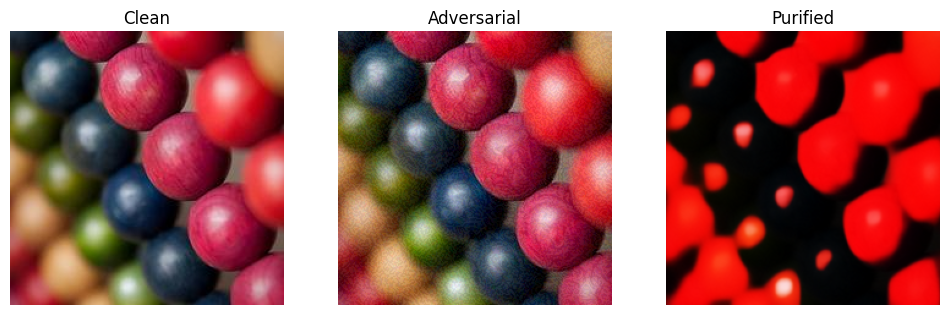

In [29]:
import matplotlib.pyplot as plt

def unnormalize_and_to_numpy(t):
    """
    t: (3,H,W), tensor in normalized space (ImageNet norm)
    return: numpy image (H,W,3) in [0,1]
    """
    t = t.detach().cpu()
    t = t * imagenet_std.cpu() + imagenet_mean.cpu()  # unnormalize
    t = torch.clamp(t, 0, 1)
    return t.permute(1, 2, 0).numpy()

# 例: Clean / Adv / Purified を表示
clean_img = unnormalize_and_to_numpy(imgs[0])        # クリーン
adv_img   = unnormalize_and_to_numpy(perturbed[0])   # 敵対
pur_img   = unnormalize_and_to_numpy(pur_clf_inp[0]) # 浄化後

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(clean_img); axs[0].set_title("Clean"); axs[0].axis("off")
axs[1].imshow(adv_img);   axs[1].set_title("Adversarial"); axs[1].axis("off")
axs[2].imshow(pur_img);   axs[2].set_title("Purified"); axs[2].axis("off")
plt.show()


IndexError: index 4 is out of bounds for dimension 0 with size 4

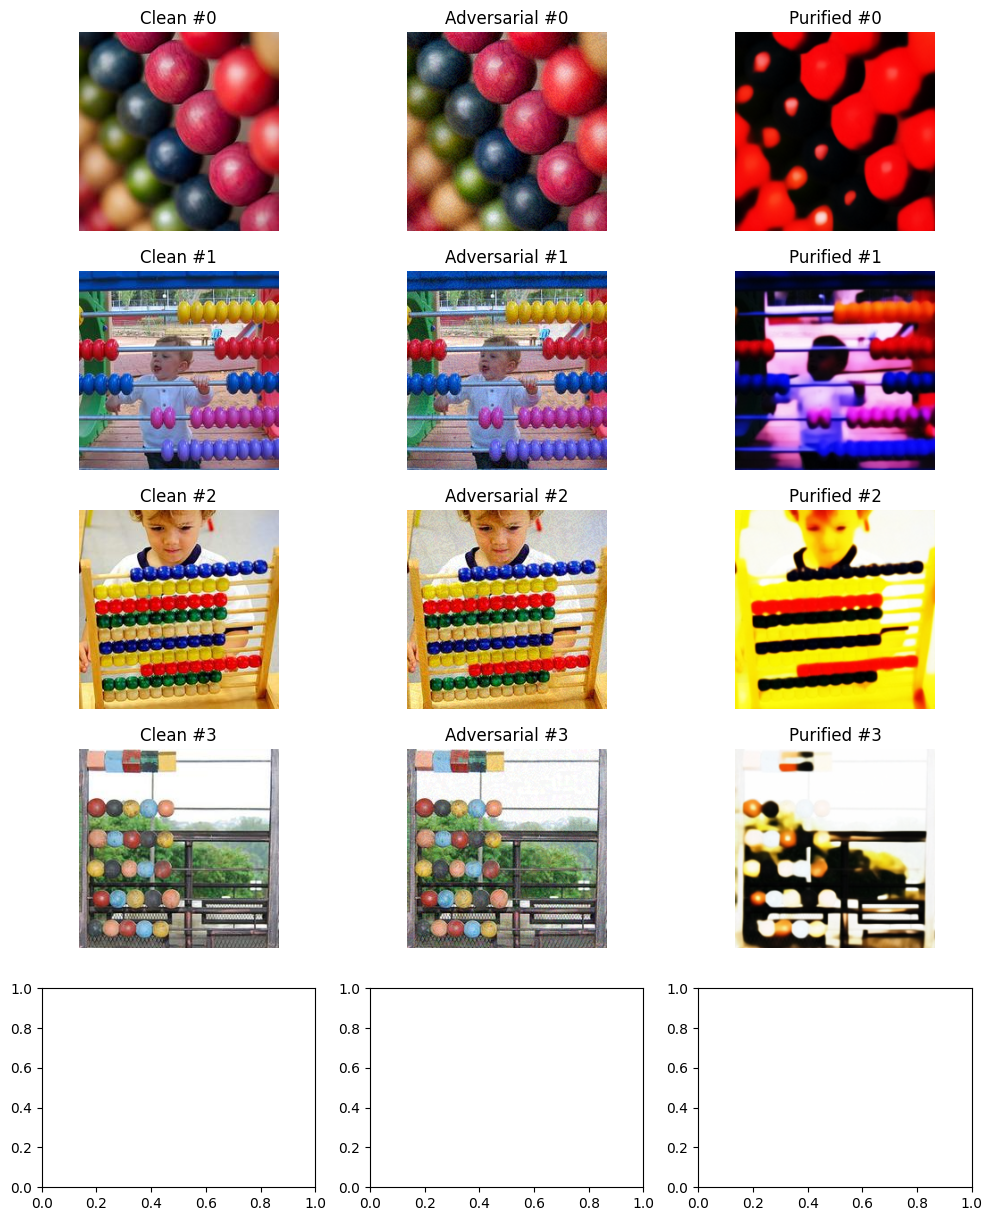

In [32]:
import matplotlib.pyplot as plt

def unnormalize_and_to_numpy(t):
    """
    t: (3,H,W), tensor in normalized space (ImageNet norm)
    return: numpy image (H,W,3) in [0,1]
    """
    t = t.detach().cpu()
    t = t * imagenet_std.cpu() + imagenet_mean.cpu()  # unnormalize
    t = torch.clamp(t, 0, 1)
    return t.permute(1, 2, 0).numpy()

# 5枚を表示
n_show = 5
fig, axs = plt.subplots(n_show, 3, figsize=(12, 3*n_show))

for i in range(n_show):
    clean_img = unnormalize_and_to_numpy(imgs[i])
    adv_img   = unnormalize_and_to_numpy(perturbed[i])
    pur_img   = unnormalize_and_to_numpy(pur_clf_inp[i])

    axs[i, 0].imshow(clean_img); axs[i, 0].set_title(f"Clean #{i}"); axs[i, 0].axis("off")
    axs[i, 1].imshow(adv_img);   axs[i, 1].set_title(f"Adversarial #{i}"); axs[i, 1].axis("off")
    axs[i, 2].imshow(pur_img);   axs[i, 2].set_title(f"Purified #{i}"); axs[i, 2].axis("off")

plt.tight_layout()
plt.show()


In [33]:
print("Purified min:", purified_neg1_1[0].min().item())
print("Purified max:", purified_neg1_1[0].max().item())
print("Purified mean:", purified_neg1_1[0].mean().item())


Purified min: -1.0
Purified max: 1.0
Purified mean: -0.6208560466766357
